# e-Science Tjärnö 

In [1]:
# Autoload external files/functions

%load_ext autoreload

%autoreload 2

In [2]:
# Import necessary libraries and functions

import xarray as xr
from sizedist_utils import compute_Nx_ebas_cleaned  # Made by Sara: size distribution to number concentration integration
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
s3.ls('escience2022')

['escience2022/Ada',
 'escience2022/Antoine',
 'escience2022/Dominic',
 'escience2022/ESA_SMOS_sss',
 'escience2022/Remy',
 'escience2022/Sara',
 'escience2022/Zhihong']

## Load and prepare data

## Load and prepare data

### Zeppelin station

In [43]:
# Zeppelin data
data1 = xr.open_dataset('/home/jovyan/Data/zeppelin-cloud-aerosol-1_part1.nc4')
data2 = xr.open_dataset('/home/jovyan/Data/zeppelin-cloud-aerosol-1_part2.nc4')


# Cloud flag
data1_cl_mask=data1.where(data1['cloud_flag']=='yes')
data1_no_cl = data1.where(data1['cloud_flag']=='no')

# Filter out cold temperatures (< -4C) to remove ice from observations

data1_cl_mask_warm=data1_cl_mask.where(data1_cl_mask['temperature'] > -4.0)


### NorESM data

In [7]:
# Pick variables -- Cloud Properties
varl = ['AWNC', 'AREL', 'FREQL', 'N100','N50', 'N30'] 

path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_ssp245/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2018-01-01_hour_locations.nc'

def make_file_path_for_var(v,):
    return path_to_data+v+postfix

filelist = [make_file_path_for_var(v) for v in varl]

list_of_s3_obj = [s3.open(s) for s in filelist]


ds = xr.open_mfdataset(list_of_s3_obj)

In [25]:
# Define and add AWNC_incld to dataset

ds['AWNC_incld'] = ds['AWNC']/ds['FREQL']

In [39]:
ds.lev[-1]

<xarray.DataArray 'lev' ()>
array(992.55609512)
Coordinates:
    lev      float64 992.6
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          hPa
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

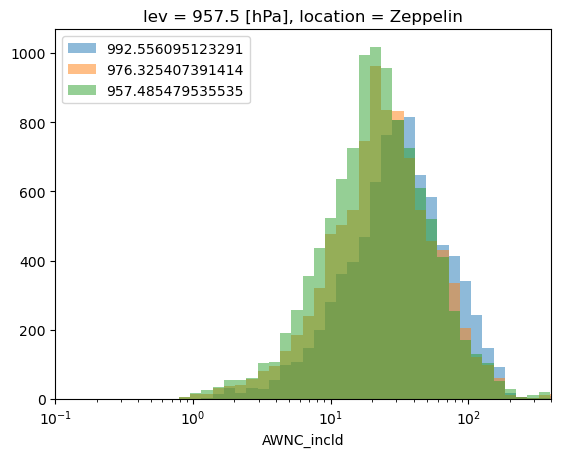

In [40]:
# Plot histograms of NorESM AWNC_incld at different levels

ds.isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3,50), alpha=.5, label=ds.lev[-1])#, density=True)
ds.isel(lev=-2).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3, 50), alpha=.5, label=ds.lev[-2])#, density = True)
ds.isel(lev=-3).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3,50), alpha=.5, label=ds.lev[-3])# , density = True)
plt.xscale('log')
plt.xlim([0.1,400])
plt.legend()

## Integrating size distribution to droplet number concentrations

Naming: 
* Nx_cloud : integrated with compute_Nx_ebas_cleaned (d>1e-9), from cloud masked cloud particle size distribution - Fog monitor
* Nx_cloudresidual : variable 'total_aerosol_particle_concentration' in cloud masked data1 - CVI
* Nx_NorESM : AWNC_incld at level -1, location Zeppelin.


In [45]:
# Calculate/extract cloud droplet number concentrations

Nx_cloud =compute_Nx_ebas_cleaned(data1_cl_mask,x=1e-9, var_diam = 'cloud_diameters', v_dNdlog10D='cloud_particle_size_distribution')
Nx_cloud_warm =compute_Nx_ebas_cleaned(data1_cl_mask_warm,x=1e-9, var_diam = 'cloud_diameters', v_dNdlog10D='cloud_particle_size_distribution')
Nx_cloudresidual = data1_cl_mask.total_aerosol_particle_concentration
Nx_cloudresidual_warm= data1_cl_mask_warm.total_aerosol_particle_concentration
Nx_NorESM = ds.isel(lev=-1).sel(location='Zeppelin')['AWNC_incld']



/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


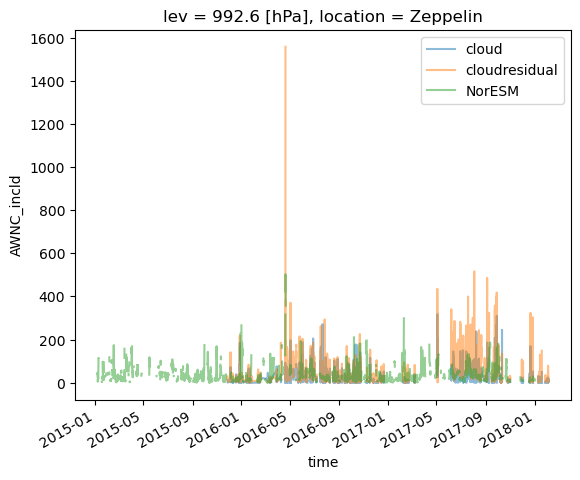

In [21]:
# Plot check
Nx_cloud.plot(alpha=0.5,label ='cloud')
Nx_cloudresidual.plot(alpha=0.5,label ='cloudresidual')
Nx_NorESM.plot(alpha=0.5, label='NorESM')
plt.legend()

### Resample observations to hourly data

In [46]:
Nx_cloud_hourly=Nx_cloud.resample(time='H').mean()
Nx_cloud_warm_hourly=Nx_cloud.resample(time='H').mean()
Nx_cloudresidual_hourly=Nx_cloudresidual.resample(time='H').mean()
Nx_cloudresidual_warm_hourly=Nx_cloudresidual_warm.resample(time='H').mean()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


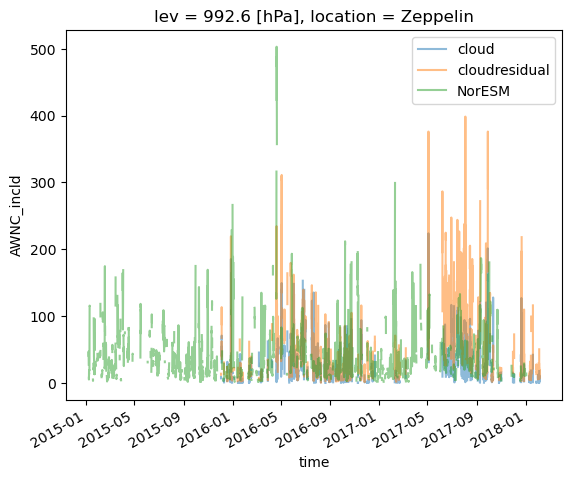

In [47]:
# Plot check

Nx_cloud_hourly.plot(alpha=0.5,label ='cloud')
Nx_cloudresidual_hourly.plot(alpha=0.5,label ='cloudresidual')
Nx_NorESM.plot(alpha=0.5, label='NorESM')
plt.legend()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


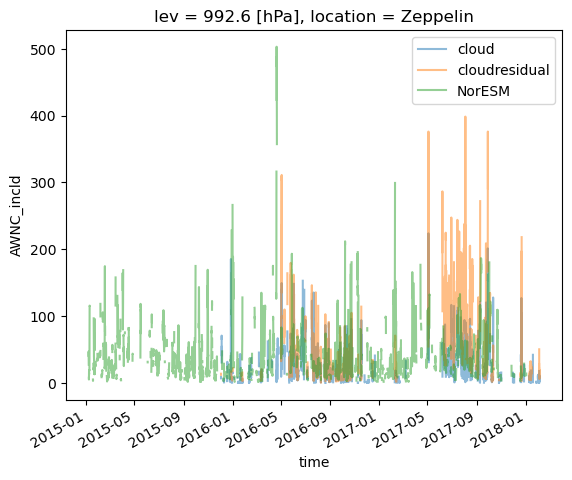

In [48]:
# Plot check

Nx_cloud_warm_hourly.plot(alpha=0.5,label ='cloud')
Nx_cloudresidual_warm_hourly.plot(alpha=0.5,label ='cloudresidual')
Nx_NorESM.plot(alpha=0.5, label='NorESM')
plt.legend()